<a href="https://colab.research.google.com/github/lorenafc/MscThesis_EyeTrackingIVR/blob/main/overlap_autoencoder_with_rf_sequence_samples_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Fixations in Eye tracking Data in Immersive Virtual Environments using Autoencoder + Random Forest

I am adapting the autoencoder + Random Forest from this original work:

" Autoencoder (MNIST) + Scikit-Learn Random Forest Classifier

A simple, single-hidden-layer, fully-connected autoencoder that compresses 768-pixel MNIST images into 32-pixel vectors (32-times smaller representations). A random forest classifier is then trained for predicting the class labels based on that 32-pixel compressed space.

Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.

Author: Sebastian Raschka GitHub Repository: https://github.com/rasbt/deeplearning-models https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/autoencoder/ae-basic-with-rf.ipynb "

CPython 3.7.3, IPython 7.9.0, torch 1.3.0

Generative AI is being used to help writting the script and debugging

In [ ]:
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import TensorDataset


In [ ]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Read the CSV file
file_name = '/content/LLA2020_labeled.csv'
# file_name = '/content/eye_tracking_data_small_2019.csv'
eye_tracking_data = pd.read_csv(file_name)

Device: cpu


In [ ]:
print(eye_tracking_data.head())
print(eye_tracking_data.shape)

    time    L_x     L_y     L_z     C_x     C_y     C_z  observer  GT1  GT2  \
0  9.314 -2.969  1.6232 -1.2434 -0.4009  1.6289 -1.2939         1    0    0   
1  9.337 -2.969  1.6255 -1.2432 -0.4007  1.6290 -1.2940         1    0    0   
2  9.360 -2.969  1.6260 -1.2447 -0.4006  1.6290 -1.2940         1    0    0   
3  9.381 -2.969  1.6232 -1.2430 -0.4004  1.6291 -1.2941         1    0    0   
4  9.403 -2.969  1.6242 -1.2410 -0.4002  1.6291 -1.2941         1    0    0   

   GT3  GT4  GT5  GT6  GT7  
0    0    0    0    0    0  
1    0    0    0    0    0  
2    0    0    0    0    0  
3    0    0    0    0    0  
4    0    0    0    0    0  
(106252, 15)


In [ ]:
eye_tracking_data_rf = eye_tracking_data.copy()

In [ ]:
# Data cleaning
eye_tracking_data = eye_tracking_data.drop(columns=['GT2', 'GT3', 'GT4', 'GT5', 'GT6', 'GT7']) # removing
eye_tracking_data = eye_tracking_data[['time', 'L_x', 'L_y', 'L_z', 'C_x', 'C_y', 'C_z', 'GT1','observer']]

In [ ]:
print(eye_tracking_data.head(3))

    time    L_x     L_y     L_z     C_x     C_y     C_z  GT1  observer
0  9.314 -2.969  1.6232 -1.2434 -0.4009  1.6289 -1.2939    0         1
1  9.337 -2.969  1.6255 -1.2432 -0.4007  1.6290 -1.2940    0         1
2  9.360 -2.969  1.6260 -1.2447 -0.4006  1.6290 -1.2940    0         1


In [ ]:
if "time_diff" not in eye_tracking_data.columns:
    eye_tracking_data["time_diff"] = ""
    eye_tracking_data["time_diff"] = eye_tracking_data["time"].diff().fillna(0)
    eye_tracking_data["time_diff"] = pd.to_numeric(eye_tracking_data["time_diff"], errors='coerce')

In [ ]:
print(eye_tracking_data.head(3))

    time    L_x     L_y     L_z     C_x     C_y     C_z  GT1  observer  \
0  9.314 -2.969  1.6232 -1.2434 -0.4009  1.6289 -1.2939    0         1   
1  9.337 -2.969  1.6255 -1.2432 -0.4007  1.6290 -1.2940    0         1   
2  9.360 -2.969  1.6260 -1.2447 -0.4006  1.6290 -1.2940    0         1   

   time_diff  
0      0.000  
1      0.023  
2      0.023  


### FEATURES

In [ ]:
eye_tracking_data_without_GT1 = eye_tracking_data.drop(columns=['GT1'])

In [ ]:
print(eye_tracking_data_without_GT1.head(3))
print("eye_tracking_data_without_GT1 shape:", eye_tracking_data_without_GT1.shape)

    time    L_x     L_y     L_z     C_x     C_y     C_z  observer  time_diff
0  9.314 -2.969  1.6232 -1.2434 -0.4009  1.6289 -1.2939         1      0.000
1  9.337 -2.969  1.6255 -1.2432 -0.4007  1.6290 -1.2940         1      0.023
2  9.360 -2.969  1.6260 -1.2447 -0.4006  1.6290 -1.2940         1      0.023
eye_tracking_data_without_GT1 shape: (106252, 9)


In [ ]:
# X train and X test without GT1

# Convert columns to float32 for compatibility with PyTorch
eye_tracking_data_without_GT1 = eye_tracking_data_without_GT1.astype('float32')
train_split = 0.75

# Creating data indices for training and test splits: source: LSTM autoencoder time series https://github.com/fabiozappo/LSTM-Autoencoder-Time-Series/blob/main/code/main.py
dataset_size = len(eye_tracking_data_without_GT1)
indices = list(range(dataset_size))
split = int(np.floor(train_split * dataset_size))

et_train_without_GT1 = eye_tracking_data_without_GT1.iloc[:split, :]
et_test_without_GT1 = eye_tracking_data_without_GT1.iloc[split:, :]

print("et_train_without_GT1 shape:", et_train_without_GT1.shape)


et_train_without_GT1 shape: (79689, 9)


### LABEL - GT1

In [ ]:
eye_tracking_data_GT1 = eye_tracking_data[['GT1']]
print(eye_tracking_data_GT1.head(3))
print("eye_tracking_data_GT1 shape:", eye_tracking_data_GT1.shape)

   GT1
0    0
1    0
2    0
eye_tracking_data_GT1 shape: (106252, 1)


In [ ]:
# Convert all columns to float32 for compatibility with PyTorch
eye_tracking_data_GT1 = eye_tracking_data_GT1.astype('float32')

train_split = 0.75
dataset_size = len(eye_tracking_data_GT1)
indices = list(range(dataset_size))
split = int(np.floor(train_split * dataset_size))

et_train_GT1 = eye_tracking_data_GT1.iloc[:split, :]
et_test_GT1 = eye_tracking_data_GT1.iloc[split:, :]

In [ ]:
print("et_train_GT1 shape:", et_train_GT1.shape)
print("et_test_GT1 shape:", et_test_GT1.shape)

et_train_GT1 shape: (79689, 1)
et_test_GT1 shape: (26563, 1)


# Create overlapping data

In [ ]:
# create overlapping data:

def subset_training_data_overlap_by_rows(
    training_data_overlap: pd.DataFrame, rows_interval: int = 460, rows_overlap: int = 135
) -> pd.DataFrame:
    """
    Splits the training_data DataFrame into overlapping subsets for each observer, using row-based intervals.
    Parameters: training_data_overlap (pd.DataFrame): The input DataFrame with an 'observer' column.
                rows_interval (int): The number of rows for each subset.
                rows_overlap (int): The number of overlapping rows for the next subset.
    Returns: pd.DataFrame: A new DataFrame with repeated overlapping rows for each observer, using global subset IDs.
    """
    # Ensure the data is sorted by observer and time
    training_data_overlap = training_data_overlap.sort_values(by=["observer", "time"]).reset_index(drop=True)

    all_subsets = []
    global_subset_id = 1

    # Iterate over each observer
    for observer_id, observer_data in training_data_overlap.groupby("observer"):
        observer_data = observer_data.reset_index(drop=True)

        # Calculate the step for each subset
        subset_step = rows_interval - rows_overlap
        n_rows = len(observer_data)

        # Create subsets using slicing
        for start_idx in range(0, n_rows, subset_step):
            end_idx = start_idx + rows_interval
            current_subset = observer_data.iloc[start_idx:end_idx].copy()

            if not current_subset.empty:
                # Label this subset with a unique global subset ID
                current_subset["subset"] = global_subset_id
                all_subsets.append(current_subset)
                global_subset_id += 1

    # Concatenate all subsets into one DataFrame
    df = pd.concat(all_subsets, ignore_index=True)
    return df

### FEATURES WITH OVERLAPPING - (TEST DATA TO TEST THE MODEL WILL NOT BE OVERLAPPED)

Test data willl not be overlaped, therefore we need to split the data before doing the overlapping

In [ ]:
### REMOVE GT1, SPLIT TRAIN/TEST, than overlap: et_train_without_GT1

### OVERLAP TRAINING DATA
# et_train_without_GT1_overlap = subset_training_data_overlap_by_rows(et_train_without_GT1_norm)
et_train_without_GT1_overlap = subset_training_data_overlap_by_rows(et_train_without_GT1)
print(f"et_train_without_GT1_overlap shape is: {et_train_without_GT1_overlap.shape}")

### DONT OVERLAP TEST DATA TO TRAIN AUTOENCODER
# et_test_without_GT1_no_overlap = et_test_without_GT1_norm.copy() #normalized
et_test_without_GT1_no_overlap = et_test_without_GT1.copy()
print(f"et_test_without_GT1_no_overlap shape is: {et_test_without_GT1_no_overlap.shape}")
et_test_without_GT1_no_overlap = et_test_without_GT1_no_overlap.astype('float32')
# et_test_without_GT1_overlap = subset_training_data_overlap_by_rows(et_test_without_GT1)

# Convert all columns to float32 for compatibility with PyTorch
et_train_without_GT1_overlap = et_train_without_GT1_overlap.astype('float32')



et_train_without_GT1_overlap shape is: (108821, 10)
et_test_without_GT1_no_overlap shape is: (26563, 9)


In [ ]:
et_train_without_GT1_overlap = et_train_without_GT1_overlap.drop(columns=['subset', 'observer', 'time'])
et_test_without_GT1_no_overlap = et_test_without_GT1_no_overlap.drop(columns=['observer', 'time'])


In [ ]:
et_train_without_GT1_overlap

,L_x,L_y,L_z,C_x,C_y,C_z,time_diff
0,-2.969,1.6232,-1.2434,-0.4009,1.6289,-1.2939,0.000
1,-2.969,1.6255,-1.2432,-0.4007,1.6290,-1.2940,0.023
2,-2.969,1.6260,-1.2447,-0.4006,1.6290,-1.2940,0.023
3,-2.969,1.6232,-1.2430,-0.4004,1.6291,-1.2941,0.021
4,-2.969,1.6242,-1.2410,-0.4002,1.6291,-1.2941,0.022
...,...,...,...,...,...,...,...
108816,-2.969,0.9573,1.8967,-0.1379,1.3900,-1.5008,0.023
108817,-2.969,0.9336,1.9018,-0.1378,1.3900,-1.5007,0.022
108818,-2.969,0.9196,1.9237,-0.1378,1.3898,-1.5007,0.021
108819,-2.969,0.9093,1.9320,-0.1377,1.3897,-1.5007,0.022


In [ ]:
et_test_without_GT1_no_overlap

,L_x,L_y,L_z,C_x,C_y,C_z,time_diff
79689,-4.9724,0.4638,4.6958,-0.1375,1.3894,-1.5004,0.022
79690,-2.9690,0.8912,2.0914,-0.1374,1.3894,-1.5003,0.022
79691,-2.9690,0.8812,2.1000,-0.1373,1.3893,-1.5001,0.022
79692,-2.9690,0.8610,2.0807,-0.1372,1.3892,-1.5000,0.022
79693,-4.8530,0.4135,4.7060,-0.1371,1.3892,-1.4997,0.023
...,...,...,...,...,...,...,...
106247,-2.9690,1.1224,0.8590,-0.1139,1.5114,-1.4982,0.023
106248,-2.9690,1.1208,0.8585,-0.1139,1.5114,-1.4982,0.023
106249,-2.9690,1.1209,0.8566,-0.1138,1.5114,-1.4983,0.022
106250,-2.9690,1.1262,0.8472,-0.1138,1.5114,-1.4984,0.022


## Data Normalization

In [ ]:
## DATA NORMALIZATION

# Good practice to keep original dataframes untouched for reusability https://www.datacamp.com/tutorial/normalization-in-machine-learning?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720821&utm_adgroupid=157156374951&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=684592139651&utm_targetid=aud-1940143831083:dsa-2218886984380&utm_loc_interest_ms=&utm_loc_physical_ms=9065007&utm_content=&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-row-p1_4-prc_5-na_6-na_7-le_8-pdsh-go_9-nb-e_10-na_11-na&gad_source=1&gclid=Cj0KCQiApNW6BhD5ARIsACmEbkV4CiclaE8Gp-cKYV-93b7n6IT0qCIhGa9hPtTT_SHKo2qodHl_i5kaAn91EALw_wcB

et_train_without_GT1_copy = et_train_without_GT1.copy()
et_test_without_GT1_copy = et_test_without_GT1.copy()


# Fit min-max scaler on training data
norm = MinMaxScaler().fit(et_train_without_GT1_overlap)

# Transform the training data
et_train_without_GT1_overlap_norm = norm.transform(et_train_without_GT1_overlap)
# et_train_without_GT1_overlap_norm = norm.transform(et_train_without_GT1)

# Use the same scaler to transform the testing set
et_test_without_GT1_no_overlap_norm = norm.transform(et_test_without_GT1_no_overlap)
#et_test_without_GT1_overlap_norm = norm.transform(et_test_without_GT1)

In [ ]:
et_train_without_GT1_overlap_norm.shape

#et_train_without_GT1_overlap.head(3)

(108821, 7)

In [ ]:
print(f"et_train_without_GT1_overlap shape is: {et_train_without_GT1_overlap.shape}")
# print(f"et_test_without_GT1_overlap shape is: {et_test_without_GT1_overlap.shape}")
print(f"et_test_without_GT1_no_overlap shape is: {et_test_without_GT1_no_overlap.shape}")

et_train_without_GT1_overlap shape is: (108821, 7)
et_test_without_GT1_no_overlap shape is: (26563, 7)


In [ ]:
print("et_train_without_GT1_overlap_norm shape is:", et_train_without_GT1_overlap_norm.shape)
print("et_test_without_GT1_no_overlap_norm shape is:", et_test_without_GT1_no_overlap_norm.shape)

et_train_without_GT1_overlap_norm shape is: (108821, 7)
et_test_without_GT1_no_overlap_norm shape is: (26563, 7)


In [ ]:
et_train_without_GT1_overlap_norm

array([[0.9590517 , 0.4440523 , 0.33516896, ..., 0.5125704 , 0.5791006 ,
        0.988464  ],
       [0.9590517 , 0.4442532 , 0.33517957, ..., 0.5127778 , 0.57890654,
        0.98884964],
       [0.9590517 , 0.4442969 , 0.33510005, ..., 0.5127778 , 0.57890654,
        0.98884964],
       ...,
       [0.9590517 , 0.38258803, 0.50303173, ..., 0.01579046, 0.17816997,
        0.98881614],
       [0.9590517 , 0.38168827, 0.5034716 , ..., 0.01558304, 0.17816997,
        0.9888329 ],
       [0.9590517 , 0.38110298, 0.50409174, ..., 0.01537514, 0.1783638 ,
        0.98884964]], dtype=float32)

In [ ]:
et_test_without_GT1_no_overlap_norm
#et_test_without_GT1_no_overlap.head(3)

array([[0.82645786, 0.34277079, 0.6499586 , ..., 0.01495957, 0.1787517 ,
        0.9888329 ],
       [0.9590517 , 0.3801071 , 0.51192015, ..., 0.01495957, 0.1789453 ,
        0.9888329 ],
       [0.9590517 , 0.37923354, 0.51237595, ..., 0.01475167, 0.17933321,
        0.9888329 ],
       ...,
       [0.9590517 , 0.40017295, 0.44647324, ..., 0.26843977, 0.18282294,
        0.9888329 ],
       [0.9590517 , 0.40063596, 0.445975  , ..., 0.26843977, 0.18262911,
        0.9888329 ],
       [0.9590517 , 0.40081066, 0.44599092, ..., 0.26864743, 0.18243527,
        0.98884964]], dtype=float32)

## FEATURES OVERLAPPED IN THE **ENCODER**

In [ ]:
# Convert the df to PyTorch tensor
def convert_to_tensor(data, dtype=torch.float32):
    if hasattr(data, 'values'):
      data_to_convert = data.values
    else:
      data_to_convert = data

    return torch.tensor(data_to_convert, dtype=dtype)

# # Convert the df to PyTorch tensor
# def convert_to_tensor(dataframe, dtype=torch.float32):
#     return torch.tensor(dataframe.values, dtype=dtype)


In [ ]:
X_train_tensor = convert_to_tensor(et_train_without_GT1_overlap_norm) #normalized data in the autoencoder1
X_2_train_tensor = X_train_tensor.clone()
X_test_tensor = convert_to_tensor(et_test_without_GT1_no_overlap_norm)
X_2_test_tensor = X_test_tensor.clone()

#### NO NEED OF LABELS FOR THE AUTOENCODEDRS!!

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"X_2_train_tensor shape: {X_2_train_tensor.shape}\n")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"X_2_test_tensor shape: {X_2_test_tensor.shape}")

X_train_tensor shape: torch.Size([108821, 7])
X_2_train_tensor shape: torch.Size([108821, 7])

X_test_tensor shape: torch.Size([26563, 7])
X_2_test_tensor shape: torch.Size([26563, 7])


In [ ]:
# Create TensorDataset for train and test sets
train_dataset = TensorDataset(X_train_tensor, X_2_train_tensor)
test_dataset = TensorDataset(X_test_tensor, X_2_test_tensor) # the test data is not overlapped

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True) #timeseries data: shuffle = False
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True) #timeseries data: shuffle = False

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"X_2_train_tensor shape: {X_2_train_tensor.shape}\n")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"X_2_test_tensor shape: {X_2_test_tensor.shape}")

X_train_tensor shape: torch.Size([108821, 7])
X_2_train_tensor shape: torch.Size([108821, 7])

X_test_tensor shape: torch.Size([26563, 7])
X_2_test_tensor shape: torch.Size([26563, 7])


In [ ]:
print(f"train_loader (does not have shape): {train_loader}")
print(f"test_loader shape: {test_loader}")

train_loader (does not have shape): <torch.utils.data.dataloader.DataLoader object at 0x7a6d753b96f0>
test_loader shape: <torch.utils.data.dataloader.DataLoader object at 0x7a6d753bb580>


# AUTOENCODER MODEL

In [ ]:
# Hyperparameters for the autoencoder model
random_seed = 123
learning_rate = 0.005
num_epochs = 5
weight_decay = 1e-5

# Model architecture settings
input_size = X_train_tensor.shape[1]

num_hidden_1 = 250  # First layer in encoder
num_hidden_2 = 5   # Compressed representation layer
# num_hidden_3 = 50   # Uncomment and change value layer 2 if use 3 layers

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        ### ENCODER
        self.encoder_layer1 = nn.Linear(input_size, num_hidden_1)
        self.encoder_layer2 = nn.Linear(num_hidden_1, num_hidden_2)
        # self.encoder_layer3 = nn.Linear(num_hidden_2, num_hidden_3)
        # self.encoder_layer2.weight.detach().normal_(0.0, 0.1)
        # self.encoder_layer2.bias.detach().zero_()


        ### DECODER
        # self.decoder_layer1 = nn.Linear(num_hidden_3, num_hidden_2)
        self.decoder_layer1 = nn.Linear(num_hidden_2, num_hidden_1)
        self.decoder_layer2 = nn.Linear(num_hidden_1, input_size)
        # self.decoder_layer2.weight.detach().normal_(0.0, 0.1)
        # self.decoder_layer2.bias.detach().zero_()

## When using the Sigmoid or TanH functions for hidden layers, it is a good practice to use a “Xavier Normal” or “Xavier Uniform” weight
## initialization (also referred to Glorot initialization, named for Xavier Glorot) and scale input data to the range 0 to 1; -1 to 1 (e.g. the range of the
## activation function) prior to training. https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

## How to Choose an Output Activation Function:  If there are two mutually exclusive classes (binary classification), then your output layer will have one node and
## a sigmoid activation function should be used.https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

    def encoder(self, x):
        x = F.sigmoid(self.encoder_layer1(x)) # 3 - relu instead of sigmoid -1, or leaky_relu, 2
        encoded = F.sigmoid(self.encoder_layer2(x))
        return encoded

    def decoder(self, encoded_x):
        x = F.leaky_relu(self.decoder_layer1(encoded_x))
        decoded = torch.sigmoid(self.decoder_layer2(x))  # Sigmoid to get values between 0 and 1
        return decoded

## if using 3 layers:

    # def encoder(self, x):
    #     x = F.sigmoid(self.encoder_layer1(x))
    #     x = F.sigmoid(self.encoder_layer2(x)) ## ADDING A 3DR LAYER
    #     encoded = F.sigmoid(self.encoder_layer3(x)) ## ADDING A 3DR LAYER
    #     return encoded

    # def decoder(self, encoded_x):
    #     x = F.sigmoid(self.decoder_layer1(encoded_x))
    #     x = F.sigmoid(self.decoder_layer2(x)) ## ADDING A 3DR LAYER
    #     decoded = torch.sigmoid(self.decoder_layer3(x))  # Sigmoid to get values between 0 and 1 ## ADDING A 3DR LAYER
    #     return decoded

    def forward(self, x):
        # Flatten input from (batch, sequence_length, features) to (batch, input_size)
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiate the model
torch.manual_seed(random_seed)
model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=weight_decay) # added regularization (weight decay) L2





#  Training

In [ ]:
# Training Loop
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (sequences, _) in enumerate(train_loader):
        sequences = sequences.to(device)

        # Forward pass
        decoded = model(sequences)

        # loss = F.binary_cross_entropy(decoded, sequences.view(sequences.size(0), -1), reduction='mean')
         # reconstruction error
        loss = F.mse_loss(decoded, sequences.view(sequences.size(0), -1)) # changed binary_cross_entropy loss to mse_loss
        optimizer.zero_grad()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Logging
        if not batch_idx % 50:
            print('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                  % (epoch + 1, num_epochs, batch_idx, len(train_loader), loss))

    print('Time elapsed: %.2f min' % ((time.time() - start_time) / 60))

print('Total Training Time: %.2f min' % ((time.time() - start_time) / 60))

Epoch: 001/005 | Batch 000/425 | Loss: 0.0848
Epoch: 001/005 | Batch 050/425 | Loss: 0.0038
Epoch: 001/005 | Batch 100/425 | Loss: 0.0132
Epoch: 001/005 | Batch 150/425 | Loss: 0.0134
Epoch: 001/005 | Batch 200/425 | Loss: 0.0328
Epoch: 001/005 | Batch 250/425 | Loss: 0.0156
Epoch: 001/005 | Batch 300/425 | Loss: 0.0096
Epoch: 001/005 | Batch 350/425 | Loss: 0.0261
Epoch: 001/005 | Batch 400/425 | Loss: 0.0230
Time elapsed: 0.04 min
Epoch: 002/005 | Batch 000/425 | Loss: 0.0354
Epoch: 002/005 | Batch 050/425 | Loss: 0.0072
Epoch: 002/005 | Batch 100/425 | Loss: 0.0037
Epoch: 002/005 | Batch 150/425 | Loss: 0.0074
Epoch: 002/005 | Batch 200/425 | Loss: 0.0318
Epoch: 002/005 | Batch 250/425 | Loss: 0.0155
Epoch: 002/005 | Batch 300/425 | Loss: 0.0068
Epoch: 002/005 | Batch 350/425 | Loss: 0.0392
Epoch: 002/005 | Batch 400/425 | Loss: 0.0213
Time elapsed: 0.09 min
Epoch: 003/005 | Batch 000/425 | Loss: 0.0286
Epoch: 003/005 | Batch 050/425 | Loss: 0.0144
Epoch: 003/005 | Batch 100/425 | L

# Using encoder with the overlapped features


In [ ]:
def process_autoencoder_data(train_dataset, test_dataset, train_loader, test_loader, num_hidden_layer):

    X_train_encoded = np.ones((len(train_dataset), num_hidden_layer))
    x_train_encoded_copy = np.ones((len(train_dataset), num_hidden_layer)) # instead of using y_train, it is actually repeating the train data because no labels will be inserted in the autoencoder

    X_test_encoded = np.ones((len(test_dataset), num_hidden_layer))
    x_test_encoded_copy = np.ones((len(test_dataset), num_hidden_layer)) # instead of using y_test, it is actually repeating the test data because no labels will be inserted in the autoencoder

    # Encode training data
    start_idx = 0
    for idx, (sequences, sequences_copy) in enumerate(train_loader): #not using labels in the autoencoder
        sequences = sequences.to(device)
        encoded = model.encoder(sequences.view(sequences.size(0), -1))

        batch_size = encoded.shape[0]
        X_train_encoded[start_idx:start_idx + batch_size] = encoded.cpu().detach().numpy()
        x_train_encoded_copy[start_idx:start_idx + batch_size] = encoded.cpu().detach().numpy()
        start_idx += batch_size

    # Encode testing data
    start_idx = 0
    for idx, (sequences, sequences_copy) in enumerate(test_loader): #not using labels in the autoencoder
        sequences = sequences.to(device)
        encoded = model.encoder(sequences.view(sequences.size(0), -1))

        batch_size = encoded.shape[0]
        X_test_encoded[start_idx:start_idx + batch_size] = encoded.cpu().detach().numpy()
        x_test_encoded_copy[start_idx:start_idx + batch_size] = encoded.cpu().detach().numpy()
        start_idx += batch_size

    return X_train_encoded, x_train_encoded_copy, X_test_encoded, x_test_encoded_copy

X_train_ae_overlap, X_2_train_ae_overlap, X_test_ae_overlap, X_2_test_ae_overlap = process_autoencoder_data(train_dataset=train_dataset,
    test_dataset=test_dataset, train_loader=train_loader,test_loader=test_loader, num_hidden_layer=num_hidden_2)

print(X_train_ae_overlap.shape)
print(X_2_train_ae_overlap.shape)
print(X_test_ae_overlap.shape)
print(X_2_test_ae_overlap.shape)

(108821, 5)
(108821, 5)
(26563, 5)
(26563, 5)


## OVERLAPPING THE LABEL GT1 - Y TRAIN -
###(Need to overlap the dataset before separatig the features and labels because of the column "observer", used in the function:  subset_training_data_overlap_by_rows)

In [ ]:
## SPLIT TRAIN/TEST, than overlap: et_train_GT1
eye_tracking_data_complete = eye_tracking_data.astype('float32')

train_split = 0.75
dataset_size = len(eye_tracking_data_complete)
indices = list(range(dataset_size))
split = int(np.floor(train_split * dataset_size))

et_train_complete = eye_tracking_data_complete.iloc[:split, :]
# et_test_GT1 = eye_tracking_data_GT1.iloc[split:, :]

### OVERLAP COMPLETE DATA - NOT POSSIBLE ONLY GT1 BECAUSE THERE IS NO OBSERVER COLUMN

et_train_complete_overlap = subset_training_data_overlap_by_rows(et_train_complete)
print(f"et_train_complete_overlap shape is: {et_train_complete_overlap.shape}\n")
print(et_train_complete_overlap.head(3))

### then REMOVE FEATUES

et_train_complete_overlap shape is: (108821, 11)

    time    L_x     L_y     L_z     C_x     C_y     C_z  GT1  observer  \
0  9.314 -2.969  1.6232 -1.2434 -0.4009  1.6289 -1.2939  0.0       1.0   
1  9.337 -2.969  1.6255 -1.2432 -0.4007  1.6290 -1.2940  0.0       1.0   
2  9.360 -2.969  1.6260 -1.2447 -0.4006  1.6290 -1.2940  0.0       1.0   

   time_diff  subset  
0      0.000       1  
1      0.023       1  
2      0.023       1  


In [ ]:
# Convert all columns to float32 for compatibility with PyTorch

et_train_GT1_overlap = et_train_complete_overlap[['GT1']]

print(f"et_train_GT1_overlap shape is: {et_train_GT1_overlap.shape}\n")

et_train_GT1_overlap shape is: (108821, 1)



# RANDOM FOREST

In [ ]:
eye_tracking_data.columns

Index(['time', 'L_x', 'L_y', 'L_z', 'C_x', 'C_y', 'C_z', 'GT1', 'observer',
       'time_diff'],
      dtype='object')

### USING ENCODER IN X TEST WITH NO OVERLAPPING

In [ ]:
et_train_without_GT1_no_time_obs = et_train_without_GT1.drop(columns=['observer', 'time'])
et_test_without_GT1_no_time_obs = et_test_without_GT1.drop(columns=['observer', 'time'])

In [ ]:
X_train_tensor_orig = convert_to_tensor(et_train_without_GT1_no_time_obs)
# X_train_tensor_orig = convert_to_tensor(et_train_without_GT1)
X_2_train_tensor_orig = X_train_tensor_orig.clone()

X_test_tensor_orig = convert_to_tensor(et_test_without_GT1_no_time_obs)
X_2_test_tensor_orig = X_test_tensor_orig.clone()

#### NO NEED OF LABELS FOR THE AUTOENCODEDRS!!

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"X_2_train_tensor shape: {X_2_train_tensor.shape}\n")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"X_2_test_tensor shape: {X_2_test_tensor.shape}")

X_train_tensor shape: torch.Size([108821, 7])
X_2_train_tensor shape: torch.Size([108821, 7])

X_test_tensor shape: torch.Size([26563, 7])
X_2_test_tensor shape: torch.Size([26563, 7])


In [ ]:
# Create TensorDataset for train and test sets
train_dataset_orig = TensorDataset(X_train_tensor_orig, X_2_train_tensor_orig) #repeat the X train (X_2_train) because the label will not be inserted in the autoenoder
test_dataset_orig = TensorDataset(X_test_tensor_orig, X_2_test_tensor_orig) #repeat the X test (X_2_train) because the label will not be inserted in the autoenoder

batch_size = 256
train_loader_orig = DataLoader(train_dataset_orig, batch_size=batch_size, shuffle=False, drop_last=True) #timeseries data so shuffle = False
test_loader_orig = DataLoader(test_dataset_orig, batch_size=batch_size, shuffle=False, drop_last=True) #timeseries data so shuffle = False

print(f"X_train_tensor_orig shape: {X_train_tensor_orig.shape}")
print(f"X_2_train_tensor_orig shape: {X_2_train_tensor_orig.shape}\n")
print(f"X_test_tensor_orig shape: {X_test_tensor_orig.shape}")
print(f"X_2_test_tensor_orig shape: {X_2_test_tensor_orig.shape}")



X_train_tensor_orig shape: torch.Size([79689, 7])
X_2_train_tensor_orig shape: torch.Size([79689, 7])

X_test_tensor_orig shape: torch.Size([26563, 7])
X_2_test_tensor_orig shape: torch.Size([26563, 7])


In [ ]:
X_train_ae_orig, y_train_ae_orig, X_test_ae_orig, y_test_ae_orig = process_autoencoder_data(train_dataset=train_dataset_orig,
    test_dataset=test_dataset_orig, train_loader=train_loader_orig,test_loader=test_loader_orig, num_hidden_layer=num_hidden_2)

In [ ]:
print(f"The X_train_ae_overlap shape is:  {X_train_ae_overlap.shape}")
print(f"The et_train_GT1_overlap shape is:  {et_train_GT1_overlap.shape}\n")
print(f"The X_test_ae_orig shape is:  {X_test_ae_orig.shape}")
print(f"The et_test_GT1 shape is:  {et_test_GT1.shape}")

The X_train_ae_overlap shape is:  (108821, 5)
The et_train_GT1_overlap shape is:  (108821, 1)

The X_test_ae_orig shape is:  (26563, 5)
The et_test_GT1 shape is:  (26563, 1)


### TESTING THE MODEL:

In [ ]:
print(f"The X_train_ae_overlap shape is:  {X_train_ae_overlap.shape}")
print(f"The et_train_GT1_overlap shape is:  {et_train_GT1_overlap.shape}\n")
print(f"The X_test_ae_orig shape is:  {X_test_ae_orig.shape}")
print(f"The et_test_GT1 shape is:  {et_test_GT1.shape}")

The X_train_ae_overlap shape is:  (108821, 5)
The et_train_GT1_overlap shape is:  (108821, 1)

The X_test_ae_orig shape is:  (26563, 5)
The et_test_GT1 shape is:  (26563, 1)


In [ ]:
# Random Forest Classifier - USING OVERLAP X FROM ENCODER AND OVERLAP Y (LABELS) FOR TRAIN. USING ORIGINAL X FROM AUTOENCODER AND Y FOR TEST
rf = RandomForestClassifier(n_estimators=50, max_depth=12, n_jobs=-1)
rf.fit(X_train_ae_overlap, et_train_GT1_overlap.values.ravel()) # #source: https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected

print(f'Train Accuracy: {rf.score(X_train_ae_overlap, et_train_GT1_overlap) * 100:.2f}%')
print(f'Test Accuracy: {rf.score(X_test_ae_orig, et_test_GT1) * 100:.2f}%')

Train Accuracy: 57.78%
Test Accuracy: 44.77%


# VISUALIZING THE GAZE DATA

<ipython-input-89-22d8b394c28f>:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')  # Choose the 'Reds' colormap


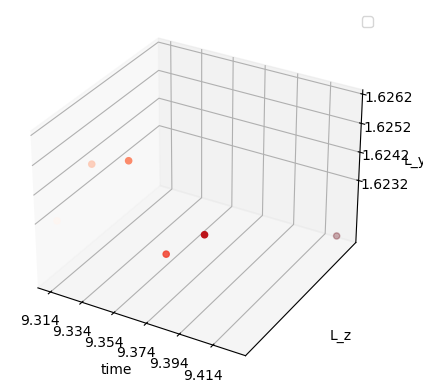

<Figure size 1500x1000 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize

ax = plt.figure().add_subplot(projection='3d')

# Make the grid
x, y, z = eye_tracking_data.loc[0:5,'time'], eye_tracking_data.loc[0:5,'L_z'], eye_tracking_data.loc[0:5,'L_y'],


# Make legend, set axes limits and labels
ax.legend()
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# ax.set_zlim(0, 1)
ax.set_xlabel('time')
ax.set_ylabel('L_z')
ax.set_zlabel('L_y')


x_start = eye_tracking_data.loc[0, 'time'] #x.iloc[0]
x_end = eye_tracking_data.loc[20, 'time']
x_tick_values = np.arange(x_start, x_end, 0.02)
plt.xticks(x_tick_values)
# plt.xticks(np.arange(9.32, 9.38, 0.02))

y_start = eye_tracking_data.loc[0, 'L_z']
y_end = eye_tracking_data.loc[20, 'L_z']
y_tick_values = np.arange(y_start, y_end, 0.0001)
plt.yticks(y_tick_values)
# plt.yticks(np.arange(-1.24450, -1.24300, 0.0005))

z_start = eye_tracking_data.loc[0, 'L_y']
z_end = eye_tracking_data.loc[20, 'L_y']
z_tick_values = np.arange(z_start, z_end, 0.001)
ax.set_zticks(z_tick_values)
# ax.set_zticks(np.arange(1.6235, 1.6260, 0.001))


# Plot scatterplot data (20 2D points per colour) on the x and z axes.
# colors = ['r', 'g', "b", "k", "pink", "orange"] # this one limits the number of points to be displayed to the same number of colors

num_points = len(x)
cmap = cm.get_cmap('Reds')
norm = Normalize(vmin=0, vmax=num_points - 1)  # Normalize data
colors = [cmap(norm(i)) for i in range(num_points)]  # Generate color sequence

ax.scatter(x, y, z,  c=colors)

fig = plt.figure(figsize=(15, 10))
fig.suptitle("Gaze Points")


plt.show()